**Домашнее задание по теме «Элементарные методы анализа временных рядов»**

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Возьмем два временных ряда: стационарный и нестационарный

In [4]:
stationary = pd.read_csv('daily-total-female-births-in-cal.csv')['Count']
non_stationary = pd.read_csv('monthly-sales-of-company-x-jan-6.csv')['Count']

In [5]:
len(stationary)

365

In [6]:
len(non_stationary)

77

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


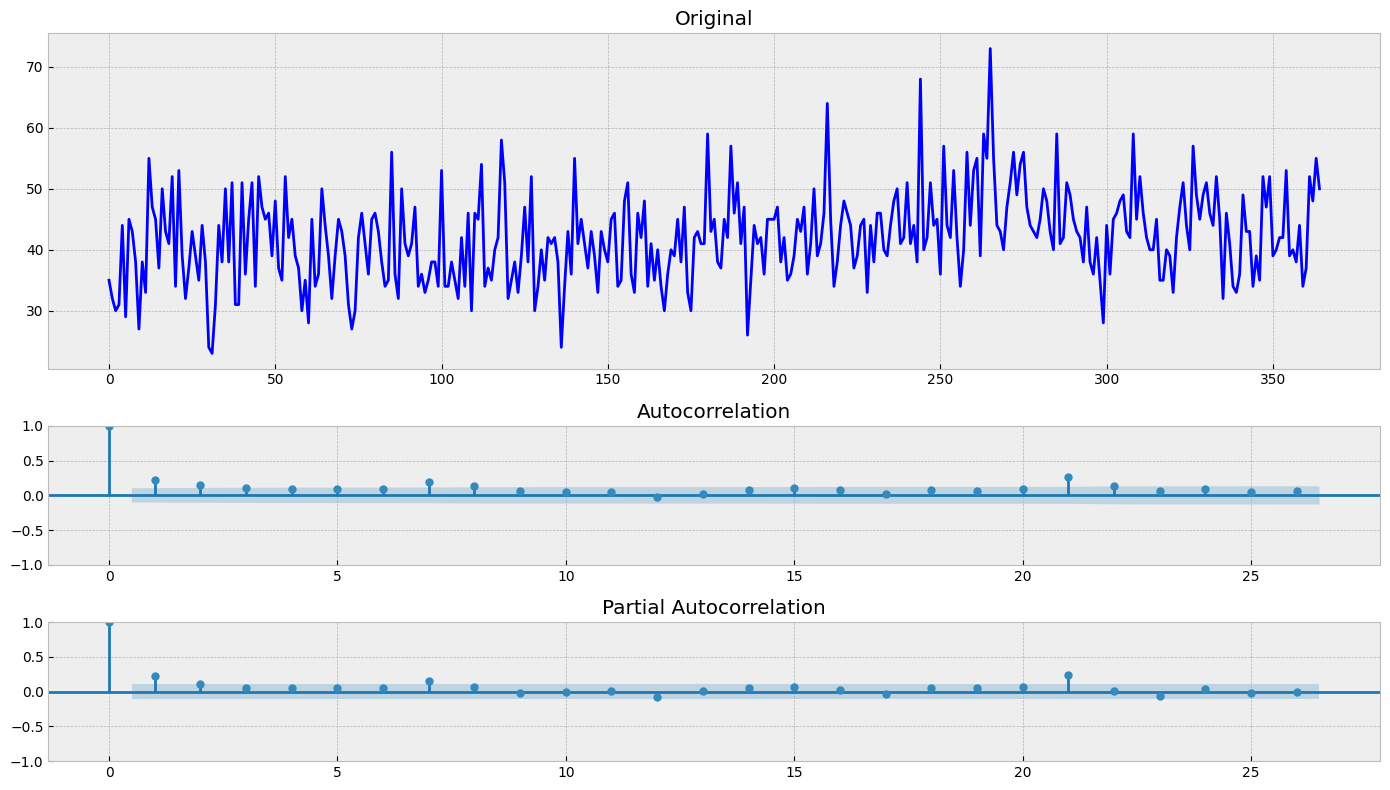

In [7]:
tsplot(stationary)

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


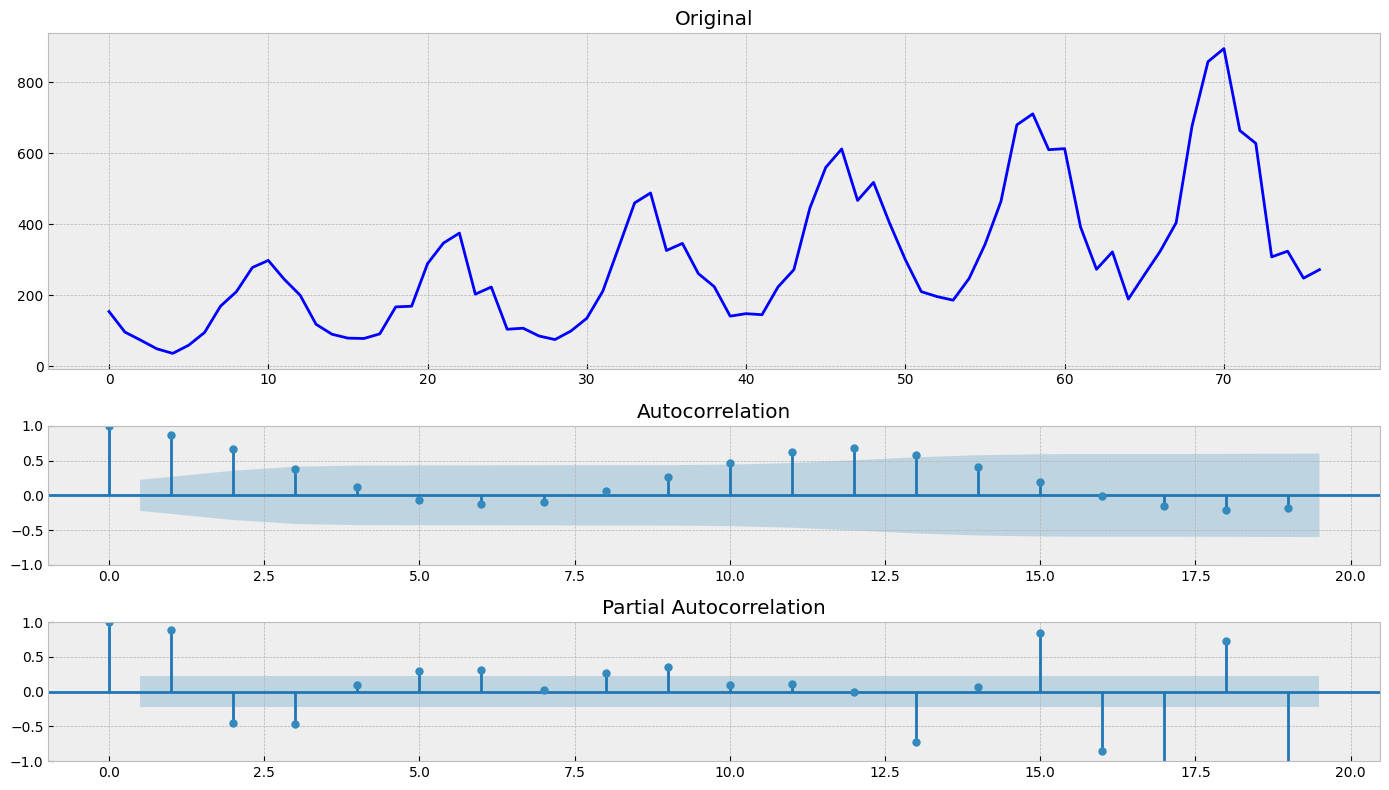

In [8]:
tsplot(non_stationary)

Для стационарного ряда для начала возьмем метод скользящего среднего, поскольку он не обладает сезонностью и трендом.

In [9]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

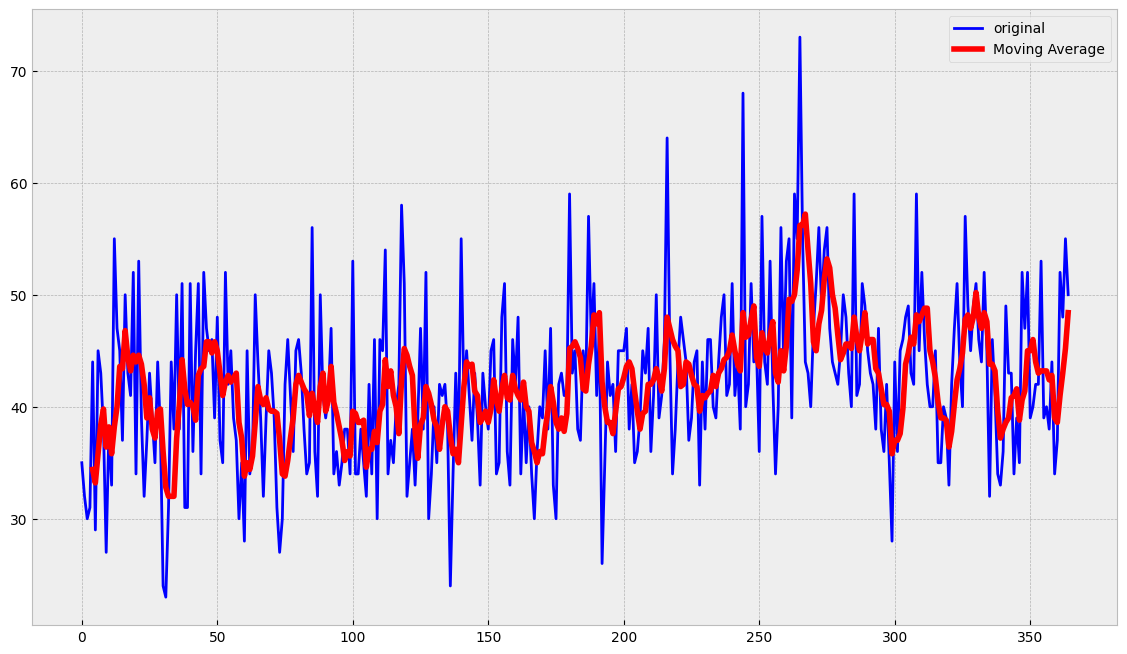

In [10]:
ser = moving_average(stationary, 5)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(stationary, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Теперь попробуем метод взвешенного скользящего среднего, при этом попробуем веса подобрать на основе ряда Фиббоначи.

In [11]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

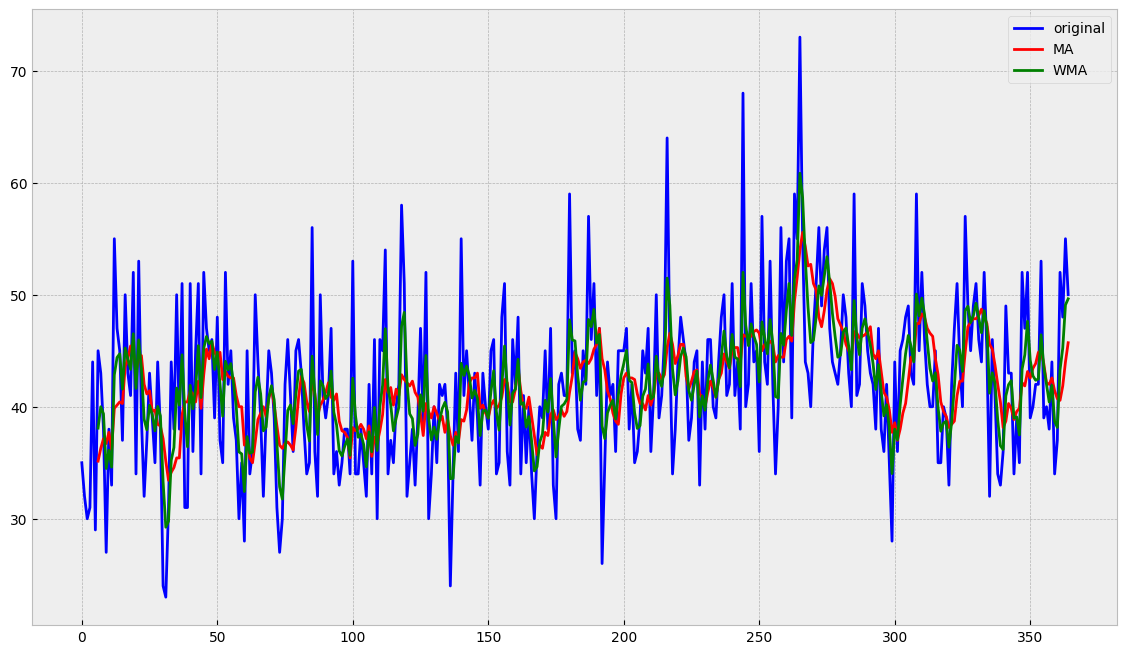

In [12]:
wma = weighted_moving_average(stationary, 7, [1,1,2,3,5,8,13])
ma = moving_average(stationary, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(stationary, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

Взвешенное скользящее среднее сработало точнее.

Для нестационарного ряда возьмем функции обычного, двойного и тройного экспоненциального сглаживания. Затем сравним.

In [13]:
def exponential_moving_average(series, alpha):
    '''Экспоненциальное сглаживание на основе гиперпараметра альфа
    '''
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [14]:
def double_ema(series, alpha, beta):
    '''Двойное экспоненциальное сглаживание на основе гиперпараметров альфа и бета'''
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [15]:
def initial_trend(series, season_len):
    for i in range(season_len):
        return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [16]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [17]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    '''Тройное экспоненциальное сглаживание на основе гиперпараметров альфа, бета и гамма
    '''
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [18]:
def plot_emas(alpha, beta, gamma, ser=non_stationary, ser_to_plot=non_stationary, n_preds= 0):
    '''Функция строит графики на основе разных видов экспоненциального сглаживания
    - обычного
    - двойного
    - тройного
    и сравнивавет с исходным рядом'''

    ema = exponential_moving_average(ser, 0.2)
    dema = double_ema(ser, alpha, beta)
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(ema, color='yellow', linewidth='4', label='EMA')
        plt.plot(dema, color='green', linewidth='4', label='DEMA')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

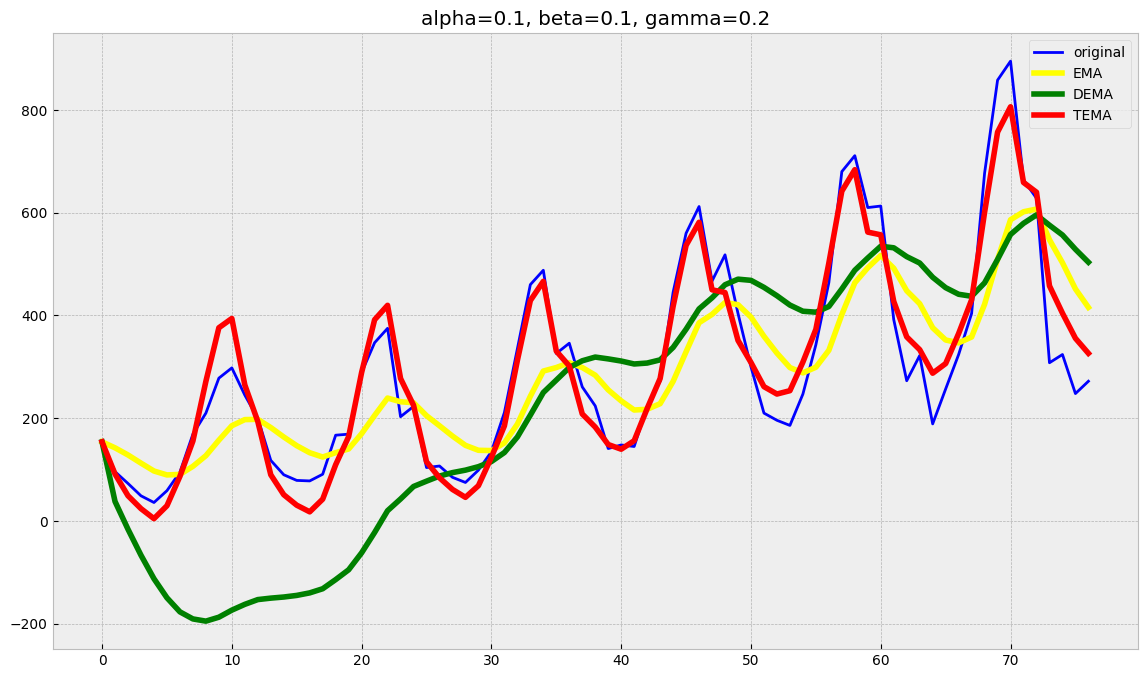

In [19]:
plot_emas(0.1, 0.1, 0.2)

Лучше всего сработало тройное экспоненциальное сглаживание, что логично, потому что в этом временном ряду прослеживается сезонность.

Посмотрим прогнозы и ошибку.

In [20]:
train, test = stationary[:270], stationary[270:]

In [21]:
def mse_stationary_wma(X):
    '''Функция подсчитывает ошибку MSE взвешенного скрользящего среднего'''
    weight = X
    result = weighted_moving_average(stationary, 7, weight)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [22]:
weights = {'Фиббоначи':[1,1,2,3,5,8,13],
           'Арифметическая прогрессия':[1,2,3,4,5,6,7],
           'Геометрическая прогрессия':[1,2,4,8,16,32,64]}

for key, value in weights.items():
    print(f'MSE: {key}: {round(mse_stationary_wma(value), 2)}')

MSE: Фиббоначи: 15.06
MSE: Арифметическая прогрессия: 23.16
MSE: Геометрическая прогрессия: 10.4


Для стационарного ряда лучше всего сработали веса на основе геометрической прогрессии.

In [23]:
result = weighted_moving_average(stationary, 7, weights['Геометрическая прогрессия'])
predictions = result[-len(test):]

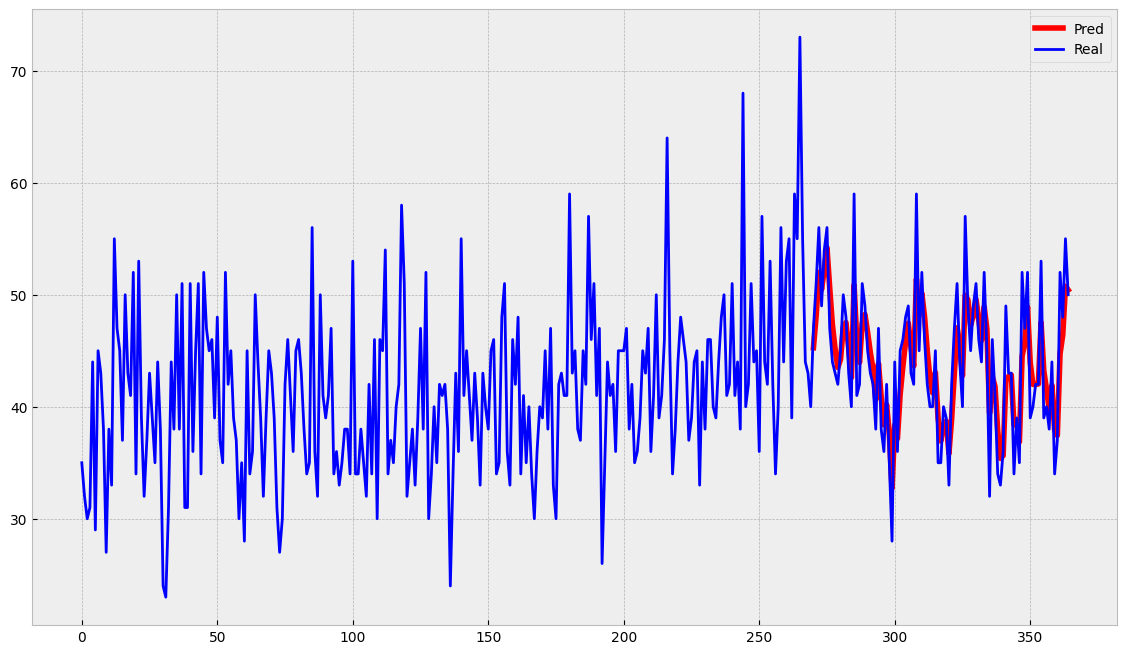

In [24]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(predictions, color='red', linewidth='4', label='Pred')
    plt.plot(stationary, color='blue', linewidth='2', label='Real')
    plt.legend()

Попробуем экспоненциальное сглаживание для предсказаний на стационарном ряде.

In [25]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)

    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)

    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

<ipython-input-25-832a5020fcc8>:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)


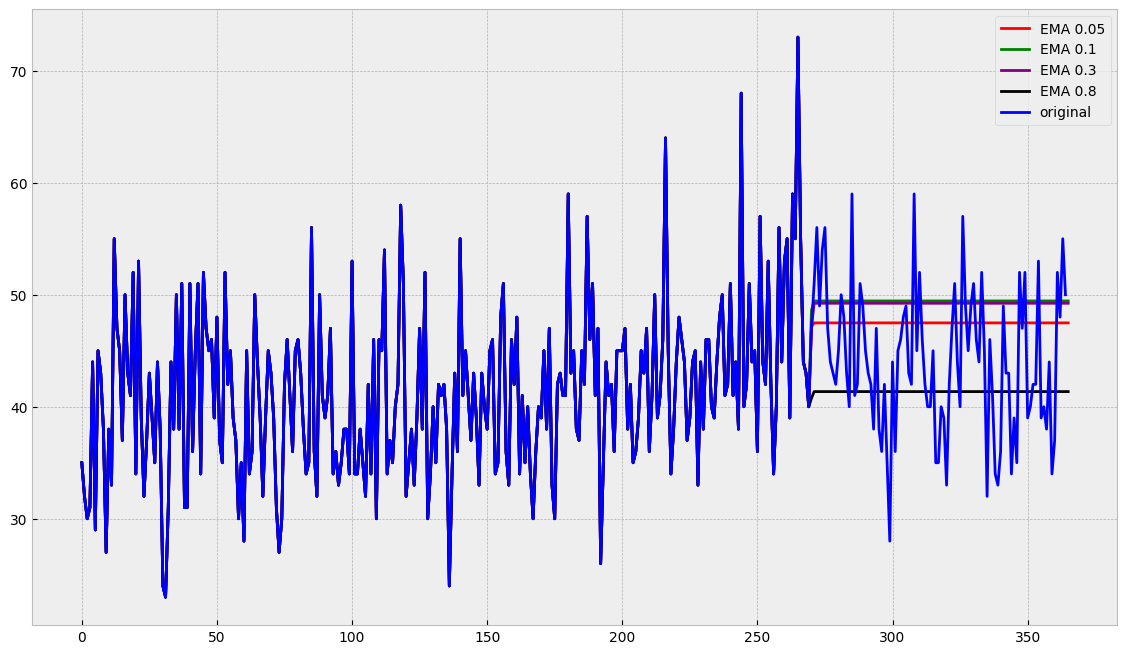

In [26]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = exponential_moving_average(train, alphas[i], len(test))
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(stationary, color='blue',label='original')
    plt.legend()

Визуально кажется, что лучше всего сработала alpha = 0.05. Но прямая - это сомнительное предсказание.

Подберем параметры и помотрим предсказания на нестационарном ряде.

In [36]:
train, val = non_stationary[:65], non_stationary[65:]

In [37]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val_tema(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3)
    errors = []

    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [39]:
opt = minimize(mse_cross_val_tema, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

32667.53509194944------------
32533.62087230721------------
32667.535091949438------------
32655.9367495519------------
32570.172122812335------------
32506.00687898621------------
32425.782340981033------------
32364.37123727628------------
32219.96112926246------------
32217.51623230029------------
32043.71344182616------------
31929.24087629642------------
31633.896947194928------------
31512.940873085314------------
31071.758024893013------------
30962.20866448022------------
30367.400249650167------------
30041.131898878055------------
29115.625337296555------------
28813.480744429427------------
27564.030888044712------------
27125.27941179695------------
25483.037394772047------------
24751.700416590775------------
22598.283839397747------------
21963.065219936776------------
19554.913565704523------------
18696.834128073828------------
16184.32103750442------------
15311.762034537234------------
13023.901431192508------------
12477.138936687617------------
10789.38891318729----

In [40]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 7180.495146687234
             x: [ 7.356e-01  1.701e-03  1.000e+00]
           nit: 97
          nfev: 173
 final_simplex: (array([[ 7.356e-01,  1.701e-03,  1.000e+00],
                       [ 7.357e-01,  1.698e-03,  1.000e+00],
                       [ 7.356e-01,  1.701e-03,  1.000e+00],
                       [ 7.357e-01,  1.689e-03,  1.000e+00]]), array([ 7.180e+03,  7.180e+03,  7.180e+03,  7.180e+03]))


In [41]:
def plot_tema(alpha, beta, gamma, ser=non_stationary, ser_to_plot=non_stationary, n_preds= 0):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)

    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

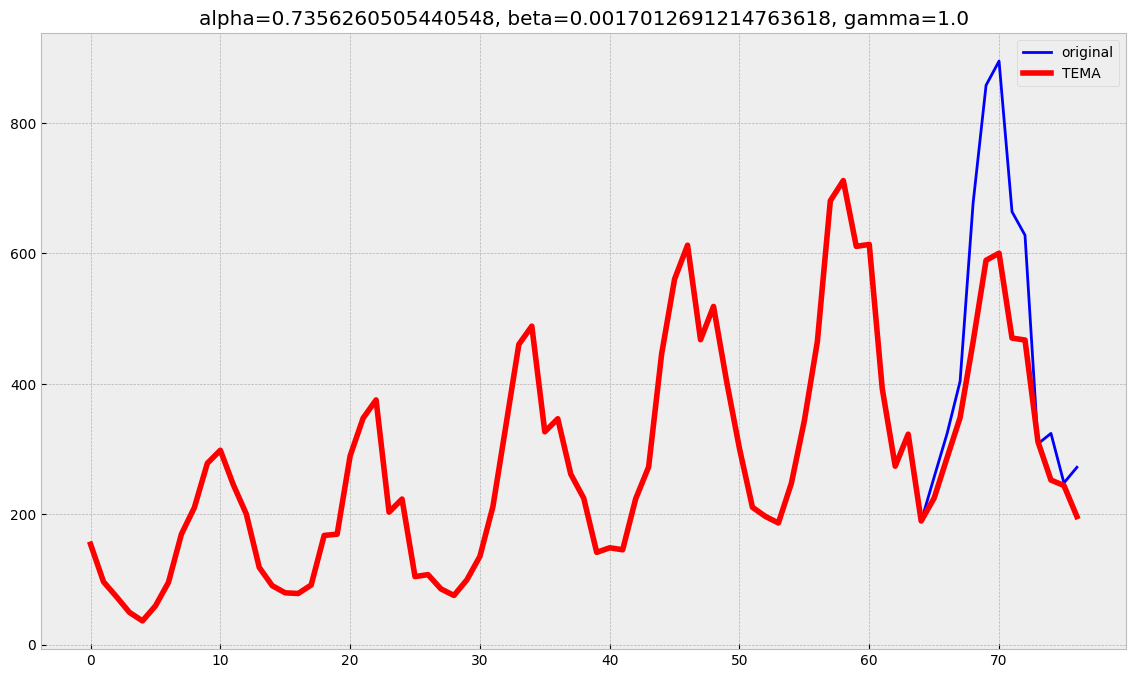

In [42]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=non_stationary, n_preds=len(val))